# Machine learning
## Research question: To what extent can clinical and proteomic biomarkers predict the likelihood that a COVID-19 patient will progress to a critical disease state?
-	Independent variables (predictors): Clinical and proteomic biomarkers
-	Dependent variable (outcome): Critical COVID-19 severity

In [1]:
# ================================================================
# 0. IMPORT LIBRARIES
# ================================================================

# Core
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
)

In [3]:
# ================================================================
# 1. LOAD THE DATASET AND HANDLE MISSING VALUES
# ================================================================

# Define all the "missing-value" indicators
missing_values = ["", "unknown", "Unknown"]

# Load combined dataset and automatically convert missing markers to NaN
combined_dataset_df = pd.read_csv("combined_dataset.csv", na_values=missing_values)

# Count missing values per column
missing_count = combined_dataset_df.isna().sum()
missing_count = missing_count[missing_count > 0]
print("Missing values per column:")
print(missing_count)

# Save version of dataset with explicit 'NaN' in CSV file
combined_dataset_df.to_csv("NaN-missing values.csv", index=False, na_rep="NaN")

Missing values per column:
ihd                              24
smoking                           8
cause_eskd                       51
WHO_severity                     53
fatal_disease                    53
radiology_evidence_covid         53
time_from_first_symptoms         82
time_from_first_positive_swab    53
dtype: int64


In [4]:
# ============================================================
# 2. CREATE A NUMERIC SEVERITY VARIABLE (severity_num)
# ============================================================
df = combined_dataset_df.copy()
# We first clean the WHO_severity and map it to an ordinal scale 1–4 and make a new column called "severity_num"
df["severity_num"] = df["WHO_severity"].astype(str).str.lower().str.strip().map({"mild":1, "moderate":2, "severe":3, "critical":4})

print("\nWHO severity cleaned value counts:")
print(df["severity_num"].value_counts(dropna=False))


WHO severity cleaned value counts:
severity_num
1.0    69
NaN    53
3.0    52
4.0    34
2.0    33
Name: count, dtype: int64


In [7]:
# ============================================================
# 3. DEFINE OUTCOME: CRITICAL VS NON-CRITICAL
# ============================================================

# We choose:
#   critical = 1  if severity_num == 4 (critical)
#   critical = 0  if severity_num in {1, 2, 3} (mild/moderate/severe)

# Drop rows without severity_num and define binary target
df = df.dropna(subset=["severity_num"]).copy()

df["severity_num"] = df["severity_num"].astype(int)
df["critical"] = (df["severity_num"] == 4).astype(int)

# Sanity check: counts and proportions
print("\nValue counts for critical (target):")
print(df["critical"].value_counts())

# Save cleaned dataset (optional)
df.to_csv("df.csv", index=False, na_rep="NaN")


Value counts for critical (target):
critical
0    154
1     34
Name: count, dtype: int64


In [38]:
# ============================================================
# 4. FEATURE MATRIX X AND TARGET VECTOR y
# ============================================================

# Define columns to exclude to avoid target leakage
columns_to_exclude = [
    "Unnamed: 0",
    "individual_id",        
    "WHO_severity",
    "WHO_temp_severity",
    "severity_num",
    "critical"
]

# Build feature matrix and target vector
feature_cols = [c for c in df.columns if c not in columns_to_exclude]
X = df[feature_cols]
y = df["critical"]

# Checks
print("\nNumber of features used:",  X.shape[1])
print(X.head(2))

print("Target vector name:", y.name)
print("Unique values in y:", y.unique())


Number of features used: 7254
   CRYBB2   RAF1  ZNF41   ELK1  GUCA1A  BECN1    OCRL  SPDEF  SNAI2  KCNAB2  \
1   304.9  862.3  132.8  745.2   256.5  174.9  2105.8  654.4  480.9   376.4   
2   318.8  967.2  143.2  725.4   243.4  161.2  1673.6  703.9  478.5   461.0   

   ...  previous_vte  copd  diabetes      smoking           cause_eskd  \
1  ...            no    no    yes.T2  not.current  DN (bx or presumed)   
2  ...            no    no    yes.T2  not.current  DN (bx or presumed)   

   fatal_disease  case_control                     radiology_evidence_covid  \
1          False      POSITIVE  yes:extensivebilateralairspaceconsolidation   
2          False      POSITIVE  yes:extensivebilateralairspaceconsolidation   

   time_from_first_symptoms  time_from_first_positive_swab  
1                       7.0                           11.0  
2                      10.0                           14.0  

[2 rows x 7254 columns]
Target vector name: critical
Unique values in y: [0 1]


Train size: 141
Test size : 47


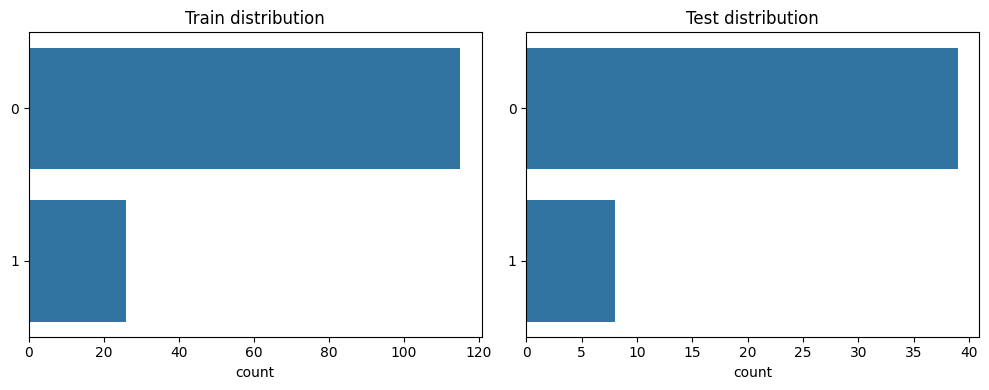

In [40]:
# ============================================================
# 5. TRAIN–TEST SPLIT (TO CONTROL OVERFITTING)
# ============================================================

# Split into train and test sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25,       # 25% for testing, 75% for training
    random_state=42,      # ensures reproducibility
    stratify=y            # keeps class proportions balanced in train/test
)

# Checks
print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])

# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(y=y_train, orient="h", ax=axes[0])
axes[0].set_title("Train distribution")
axes[0].set_ylabel("")  # remove y-axis title

sns.countplot(y=y_test, orient="h", ax=axes[1])
axes[1].set_title("Test distribution")
axes[1].set_ylabel("")   # remove y-axis title
plt.tight_layout()
plt.show()

# Note: dataset is imbalanced -> keep in mind for the interpretation

In [44]:
# ============================================================
# 6. PREPROCESSING: NUMERIC + CATEGORICAL FEATURES
# ============================================================
# We will:
#   - standardize numeric features
#   - one-hot encode categorical features

# Identify numeric vs categorical columns AFTER imputation
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# Checks
print("\nNumeric features:", len(numeric_cols))
print("Categorical features:", len(categorical_cols))


Numeric features: 7243
Categorical features: 11


In [46]:
# ----------------------------
# 6.1 Build preprocessing pipelines
# ----------------------------
# Numeric pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),   # impute missing numeric values
    ('scaler', StandardScaler())                     # standardize numeric values
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # impute missing categorical values
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ColumnTransformer combines them
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [68]:
# ----------------------------
# 6.2 Fit pipeline on training data
# ----------------------------
X_train_processed = preprocessor.fit_transform(X_train)

# ----------------------------
# 6.3 Transform on test data
# ----------------------------
X_test_processed = preprocessor.transform(X_test)

print("Train shape after preprocessing:", X_train_processed.shape)
print("Test shape after preprocessing :", X_test_processed.shape)

Train shape after preprocessing: (141, 7282)
Test shape after preprocessing : (47, 7282)


In [76]:
# ----------------------------
# 6.4 Check Numeric Standardization
# ----------------------------
X_num_scaled = preprocessor.named_transformers_["num"].transform(X[numeric_cols])

print("Means after scaling (≈0):", X_num_scaled.mean(axis=0))
print("Std devs after scaling (≈1):", X_num_scaled.std(axis=0))

# ----------------------------
# 6.5 Check One-Hot Encoding
# ----------------------------
cat_feature_names = preprocessor.named_transformers_["cat"].named_steps["encoder"].get_feature_names_out(categorical_cols)

print("Total categorical features:", len(cat_feature_names))
print("Example categorical features expanded into:", cat_feature_names[:10])

# ----------------------------
# 6.6 Check on NaNs
# ----------------------------
print("NaNs remaining in X_train_processed:", np.isnan(X_train_processed).sum())
print("NaNs remaining in X_test_processed:", np.isnan(X_test_processed).sum())

Means after scaling (≈0): [-0.04662984  0.08327325 -0.08972232 ... -0.07125137  0.0470068
 -0.00276079]
Std devs after scaling (≈1): [0.87978838 0.99436169 0.95882259 ... 1.06160981 0.97603324 1.02383336]
Total categorical features: 39
Example categorical features expanded into: ['ethnicity_asian' 'ethnicity_black' 'ethnicity_other' 'ethnicity_white'
 'sex_F' 'sex_M' 'ihd_no' 'ihd_yes.cabg' 'ihd_yes.no.intervention'
 'ihd_yes.stent']
NaNs remaining in X_train_processed: 0
NaNs remaining in X_test_processed: 0


In [65]:
# ----------------------------
# 6.7 Reconstruct DataFrame with Feature Names
# ----------------------------
num_features = numeric_cols
cat_features = cat_feature_names

# Combine numeric + categorical feature names
all_features = list(num_features) + list(cat_features)

# Training set
X_train_df = pd.DataFrame(X_train_processed, columns=all_features, index=X_train.index)
X_train_df["critical"] = y_train.values
X_train_df.to_csv("ML_transformed_train.csv", index=False)

# Test set
X_test_df = pd.DataFrame(X_test_processed, columns=all_features, index=X_test.index)
X_test_df["critical"] = y_test.values
X_test_df.to_csv("ML_transformed_test.csv", index=False)

In [78]:
# ============================================================
# 7. Logistic Regression Pipeline + Hyperparameter Tuning 
# ============================================================

# ----------------------------
# 7.1 Step 1: Build pipeline (preprocessing + model)
# ----------------------------
logreg_clf = Pipeline(steps=[
    ("preprocess", preprocessor),  
    ("model", LogisticRegression(max_iter=500, random_state=42, class_weight="balanced"))
])

# ----------------------------
# 7.2 Step 2: Define param grid 
# ----------------------------
param_grid = {
    "model__C": [0.01, 0.1, 1, 10],   # regularization strength
    "model__penalty": ["l2"],         # penalty type
    "model__solver": ["lbfgs"]        # solver supporting the chosen penalty
}

grid_search = GridSearchCV(
    logreg_clf,
    param_grid,
    cv=5,
    scoring="accuracy"
)

# ----------------------------
# 7.3 Step 3: Fit grid search on training data
# ----------------------------
grid_search.fit(X_train, y_train)

print("Best parameters found by GridSearchCV:", grid_search.best_params_)

# ----------------------------
# 7.4 Step 4: Use the best estimator
# ----------------------------
best_logreg_pipeline = grid_search.best_estimator_

# ----------------------------
# 7.5 Step 5: Cross-validated training accuracy
# ----------------------------
cv_scores = cross_val_score(best_logreg_pipeline, X_train, y_train, cv=5, scoring="accuracy")
print("Cross-validated training accuracy scores:", cv_scores)
print("Mean CV training accuracy:", cv_scores.mean())

# ----------------------------
# 7.6 Step 6: Evaluate on test set
# ----------------------------
y_test_pred_logreg = best_logreg_pipeline.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_logreg))
print("\nConfusion Matrix (Test set):")
print(confusion_matrix(y_test, y_test_pred_logreg))
print("\nClassification Report (Test set):")
print(classification_report(y_test, y_test_pred_logreg))

Best parameters found by GridSearchCV: {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Cross-validated training accuracy scores: [0.96551724 0.92857143 1.         0.96428571 0.96428571]
Mean CV training accuracy: 0.9645320197044335

Test Accuracy: 0.9361702127659575

Confusion Matrix (Test set):
[[38  1]
 [ 2  6]]

Classification Report (Test set):
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        39
           1       0.86      0.75      0.80         8

    accuracy                           0.94        47
   macro avg       0.90      0.86      0.88        47
weighted avg       0.93      0.94      0.93        47



In [80]:
# ============================================================
# 8. Random Forest Pipeline + Hyperparameter Tuning
# ============================================================

# ----------------------------
# 8.1 Step 1: Build pipeline (preprocessing + model)
# ----------------------------
rf_clf = Pipeline(steps=[
    ("preprocess", preprocessor),   # your ColumnTransformer
    ("model", RandomForestClassifier(random_state=42, class_weight="balanced"))
])

# ----------------------------
# 8.2 Step 2: Define param grid
# ----------------------------
param_grid = {
    "model__n_estimators": [100, 200, 500],   # number of trees
    "model__max_depth": [None, 5, 10, 20],    # tree depth
    "model__min_samples_split": [2, 5, 10],   # min samples to split
    "model__min_samples_leaf": [1, 2, 4]      # min samples per leaf
}

grid_search = GridSearchCV(
    rf_clf,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# ----------------------------
# 8.3 Step 3: Fit grid search on training data
# ----------------------------
grid_search.fit(X_train, y_train)
print("Best parameters found by GridSearchCV:", grid_search.best_params_)

# ----------------------------
# 8.4 Step 4: Use the best estimator
# ----------------------------
best_rf_pipeline = grid_search.best_estimator_

# ----------------------------
# 8.5 Step 5: Cross-validated training accuracy
# ----------------------------
cv_scores = cross_val_score(best_rf_pipeline, X_train, y_train, cv=5, scoring="accuracy")
print("Cross-validated training accuracy scores:", cv_scores)
print("Mean CV training accuracy:", cv_scores.mean())

# ----------------------------
# 8.6 Step 6: Evaluate on test set
# ----------------------------
y_test_pred_rf = best_rf_pipeline.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print("\nConfusion Matrix (Test set):")
print(confusion_matrix(y_test, y_test_pred_rf))
print("\nClassification Report (Test set):")
print(classification_report(y_test, y_test_pred_rf))

Best parameters found by GridSearchCV: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 500}
Cross-validated training accuracy scores: [0.86206897 0.85714286 0.85714286 0.89285714 0.92857143]
Mean CV training accuracy: 0.8795566502463054

Test Accuracy: 0.8723404255319149

Confusion Matrix (Test set):
[[39  0]
 [ 6  2]]

Classification Report (Test set):
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        39
           1       1.00      0.25      0.40         8

    accuracy                           0.87        47
   macro avg       0.93      0.62      0.66        47
weighted avg       0.89      0.87      0.84        47



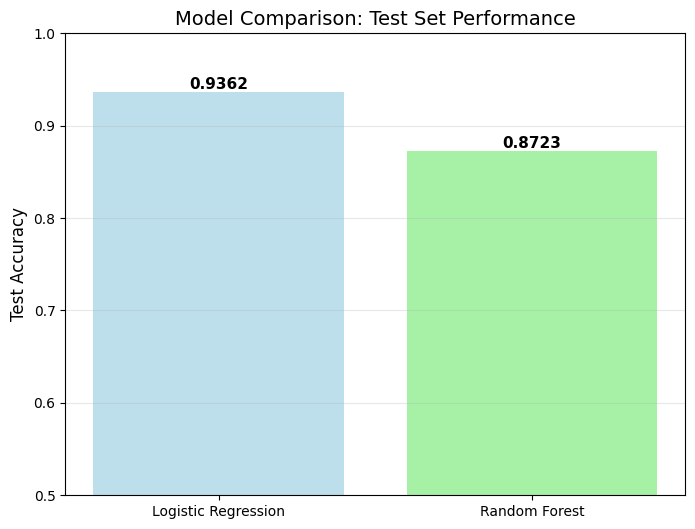

In [82]:
# ============================================================
# 9. Model Comparison Visualization
# ============================================================
test_accuracy_logreg = accuracy_score(y_test, y_test_pred_logreg)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))

model_names = ['Logistic Regression', 'Random Forest']
accuracies = [test_accuracy_logreg, test_accuracy_rf]
colors_chart = ['lightblue', 'lightgreen']

bars = ax1.bar(model_names, accuracies, color=colors_chart, alpha=0.8)

ax1.set_ylabel('Test Accuracy', fontsize=12)
ax1.set_title('Model Comparison: Test Set Performance', fontsize=14)
ax1.set_ylim([0.5, 1.0])
ax1.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.show()

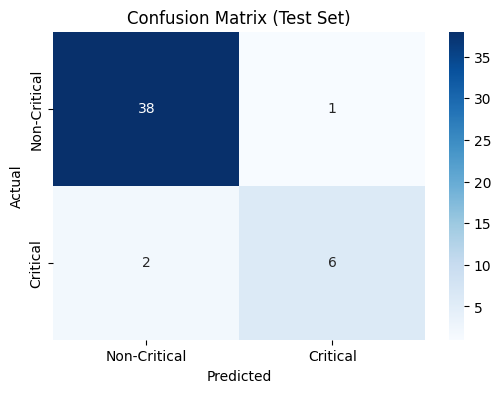

In [84]:
# ============================================================
# 10. Confusion Matrix Visualization 
# ============================================================
#We choose the Logistic Regresion because it has a higher accuracy
#Also based on Random forest confusion matrix-preview -> it would classify 6 criticals as non-critical, while LogReg does it the other way around
#This means that LogReg has fewer False negatives and RandomForest has poor sensitivity (misses most critical cases).

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred_logreg)

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Critical", "Critical"],
            yticklabels=["Non-Critical", "Critical"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.show()

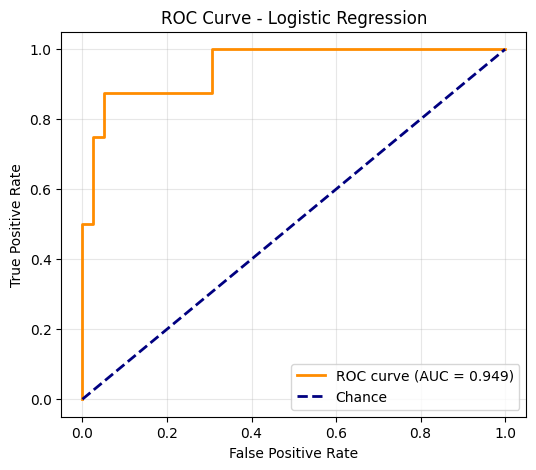

In [86]:
# ============================================================
# 11. ROC Curve for Logistic Regression
# ============================================================


# Get predicted probabilities for the positive class (critical)
y_test_proba = best_logreg_pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

# Plot ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

C:\Users\runed\AppData\Local\Temp\ipykernel_13584\2267104507.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df_logreg.head(20), x="importance", y="feature", palette="coolwarm")


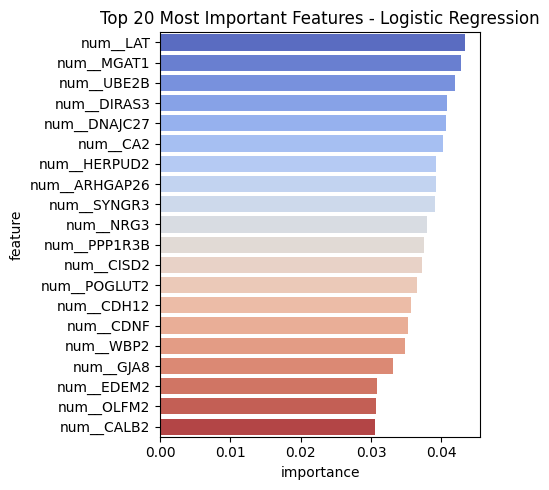

In [88]:
# ============================================================
# 12. Feature Importance (Logistic Regression)
# ============================================================

# Extract feature names after preprocessing
feature_names = best_logreg_pipeline.named_steps["preprocess"].get_feature_names_out()

# Extract coefficients from the logistic regression model
coefficients = best_logreg_pipeline.named_steps["model"].coef_[0]  # binary classification → one row

# Create DataFrame
fi_df_logreg = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients,
    "importance": abs(coefficients)   # absolute value for strength
}).sort_values(by="importance", ascending=False)

# Plot top 20
plt.figure(figsize=(5,5))
sns.barplot(data=fi_df_logreg.head(20), x="importance", y="feature", palette="coolwarm")
plt.title("Top 20 Most Important Features - Logistic Regression")
plt.tight_layout()
plt.show()